# Download dataset

In [1]:
!mkdir /content/dataset

In [2]:
%cp /content/drive/MyDrive/Colab/pydomains/screenshots/processed/processed.tar /content/dataset/

In [3]:
%cd /content/dataset

/content/dataset


In [4]:
!tar xf processed.tar

In [5]:
!ls -ltr

total 4256372
drwxr-xr-x 56 root root       4096 Dec  7 21:55 processed
-rw-------  1 root root 4358516443 Dec  8 22:55 processed.tar


In [8]:
!find processed -type f | wc -l

199190


# Resource Details

In [175]:
!nvidia-smi

Fri Dec  9 02:18:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    50W / 400W |   3560MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [178]:
!cat /proc/cpuinfo | grep ^processor

processor	: 0
processor	: 1
processor	: 2
processor	: 3
processor	: 4
processor	: 5
processor	: 6
processor	: 7
processor	: 8
processor	: 9
processor	: 10
processor	: 11


In [180]:
!cat /proc/meminfo | grep ^MemTotal

MemTotal:       87538764 kB


GPU - A100 <br>
CPU - 12 cores <br>
RAM - 88 GB <br>

# View samples in data

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import tensorflow as tf
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [10]:

data_dir = pathlib.Path("/content/dataset/processed")

In [11]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

199190


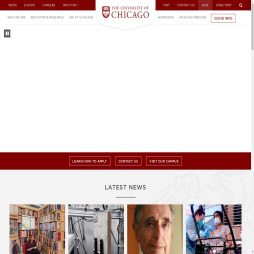

In [14]:
education = list(data_dir.glob('education/*'))
PIL.Image.open(str(education[0]))

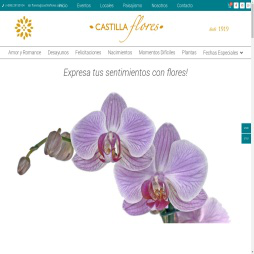

In [17]:
shopping = list(data_dir.glob('shopping/*'))
PIL.Image.open(str(shopping[0]))

# Split dataset

In [77]:
batch_size = 32
img_height = 160
img_width = 160

In [78]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 199190 files belonging to 54 classes.
Using 159352 files for training.


In [79]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 199190 files belonging to 54 classes.
Using 39838 files for validation.


In [80]:
class_names = train_ds.class_names
print(class_names)

['adv', 'aggressive', 'alcohol', 'anonvpn', 'automobile', 'costtraps', 'dating', 'downloads', 'drugs', 'dynamic', 'education', 'finance', 'fortunetelling', 'forum', 'gamble', 'government', 'hacking', 'hobby', 'homestyle', 'hospitals', 'imagehosting', 'isp', 'jobsearch', 'library', 'military', 'models', 'movies', 'music', 'news', 'podcasts', 'politics', 'porn', 'radiotv', 'recreation', 'redirector', 'religion', 'remotecontrol', 'ringtones', 'science', 'searchengines', 'sex', 'shopping', 'socialnet', 'spyware', 'tracker', 'updatesites', 'urlshortener', 'violence', 'warez', 'weapons', 'webmail', 'webphone', 'webradio', 'webtv']


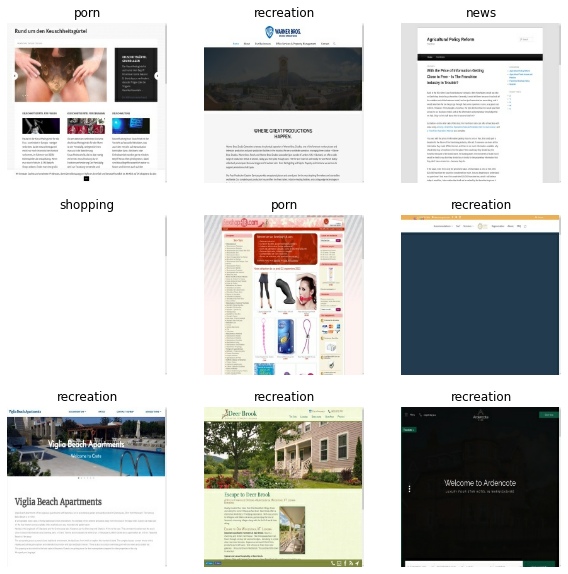

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [82]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [83]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [84]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 996
Number of test batches: 249


In [85]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Tranfer learning using MobilenetV2
With input size 160x160

In [114]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [115]:
IMG_SIZE = (img_width, img_height)
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [116]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [117]:
base_model.trainable = False

In [118]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_9[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [119]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [120]:
prediction_layer = tf.keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 54)


In [121]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [122]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [123]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [124]:
len(model.trainable_variables)


2

# Evaluate on validation set before training

In [125]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

996/996 [==============================] - 50s 38ms/step - loss: 4.2795 - accuracy: 0.0112


In [126]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.28
initial accuracy: 0.01


# Train model

In [127]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
4980/4980 [==============================] - 245s 49ms/step - loss: 1.9131 - accuracy: 0.4386 - val_loss: 1.7375 - val_accuracy: 0.4897
Epoch 2/10
4980/4980 [==============================] - 243s 49ms/step - loss: 1.7479 - accuracy: 0.4864 - val_loss: 1.6952 - val_accuracy: 0.5024
Epoch 3/10
4980/4980 [==============================] - 251s 50ms/step - loss: 1.7051 - accuracy: 0.4965 - val_loss: 1.6800 - val_accuracy: 0.5059
Epoch 4/10
4980/4980 [==============================] - 248s 50ms/step - loss: 1.6825 - accuracy: 0.4997 - val_loss: 1.6701 - val_accuracy: 0.5084
Epoch 5/10
4980/4980 [==============================] - 246s 49ms/step - loss: 1.6673 - accuracy: 0.5016 - val_loss: 1.6660 - val_accuracy: 0.5097
Epoch 6/10
4980/4980 [==============================] - 246s 49ms/step - loss: 1.6553 - accuracy: 0.5025 - val_loss: 1.6642 - val_accuracy: 0.5109
Epoch 7/10
4980/4980 [==============================] - 246s 49ms/step - loss: 1.6474 - accuracy: 0.5039 - val_loss: 1

# Plot accuracy

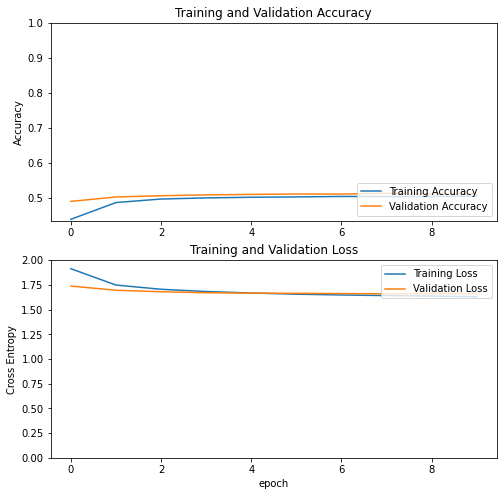

In [174]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluate model on validation set after training

In [129]:
loss0, accuracy0 = model.evaluate(val_ds)

996/996 [==============================] - 52s 42ms/step - loss: 1.6616 - accuracy: 0.5108


# Evaluate model on test set 

In [130]:
loss0, accuracy0 = model.evaluate(test_dataset)

249/249 [==============================] - 11s 41ms/step - loss: 1.6429 - accuracy: 0.5118


In [145]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)


In [146]:
image_batch.shape

(32, 160, 160, 3)

In [147]:
label_batch.shape

(32,)

In [149]:
predictions.shape

(32, 54)

In [150]:
tf.nn.softmax(predictions)

<tf.Tensor: shape=(32, 54), dtype=float32, numpy=
array([[8.9035522e-05, 5.1998113e-06, 4.0287679e-05, ..., 1.5458761e-13,
        8.3521729e-05, 6.2065205e-06],
       [2.5087469e-03, 1.7745665e-04, 2.4502218e-04, ..., 1.0986904e-16,
        2.2799602e-04, 1.1869070e-06],
       [2.1791125e-03, 6.8100810e-04, 1.9030535e-04, ..., 2.1628155e-05,
        2.9741991e-03, 2.4444619e-04],
       ...,
       [9.0635906e-04, 3.9838499e-04, 4.4752494e-04, ..., 3.2443788e-07,
        1.1117908e-02, 2.0626474e-03],
       [2.5274330e-03, 1.5421088e-04, 1.4165971e-04, ..., 3.1770885e-08,
        1.6471968e-03, 9.6143526e-04],
       [1.4931300e-03, 9.0332083e-05, 9.4417912e-05, ..., 4.9969321e-06,
        2.1857137e-03, 1.0095534e-03]], dtype=float32)>

In [157]:
preds = tf.math.argmax(tf.nn.softmax(predictions), axis=1)

In [162]:
preds.numpy()

array([31, 33, 31, 33, 31, 33, 17, 33, 41, 41, 31, 33, 33, 41, 33, 33, 41,
       33, 33, 41, 31, 31, 33, 33, 33, 31, 31, 33, 33, 33, 33, 33])

In [163]:
label_batch

array([31, 33, 41, 33, 41, 14, 17, 33, 41, 33, 33, 33, 28, 28, 33, 33, 41,
       33, 33, 33, 31, 31, 33, 33, 33, 31, 13, 41, 33,  4, 11, 33],
      dtype=int32)

In [161]:
preds[0].numpy()

31

# Display predictions

In [173]:
plt.figure(figsize=(25, 25))
for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f"{class_names[label_batch[i]]} - pred:{class_names[preds[i].numpy()]}")
  plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

# Save Model

In [181]:
!pwd

/content/dataset


In [182]:
!mkdir -p saved_model
model.save('saved_model/pydomains_images')

In [183]:
!ls -ltr

total 4256376
drwxr-xr-x 56 root root       4096 Dec  7 21:55 processed
-rw-------  1 root root 4358516443 Dec  8 22:55 processed.tar
drwxr-xr-x  3 root root       4096 Dec  9 02:26 saved_model


In [184]:
!tar cf saved_model.tar saved_model/

In [185]:
!cp saved_model.tar /content/drive/MyDrive/Colab/pydomains/screenshots/processed/